## (Breve) Análisis preliminar: asunciones básicas sobre los datos

Antes de abordar un enfoque funcional, estudiamos algunas hipótesis iniciales sobre el comportamiento de los datos:

- **¿Cuánto aumenta a la evaluación media el hacer trampas?**  
  - ¿Es proporcional a la cantidad de movimientos tramposos?

- **¿Hacer trampas acorta la duración de las partidas?**  

- **¿Cuánto de más precisos son los movimientos tramposos respecto a los normales?**


In [ ]:
# Cargamos los datos
import pickle
evals = pickle.load(open("evals.pkl", "rb"))
cheating_pos = pickle.load(open("cheating_pos.pkl", "rb"))
cheating_magnitude = pickle.load(open("cheating_magnitude.pkl", "rb"))
cheating = pickle.load(open("cheating.pkl", "rb"))
cheating_side = pickle.load(open("cheating_side.pkl", "rb"))

Parámetros: A = 2.8100781479478947, B = 1.7252114639566138


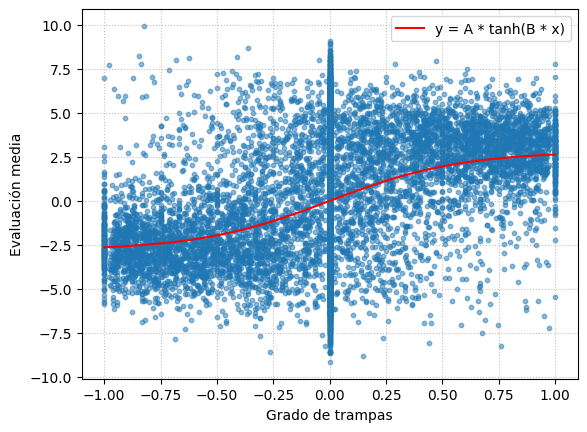

In [210]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Calculamos las evaluciones medias de cada partida
avg_eval = [np.sum(evals[i]) / len(evals[i]) for i in range(len(evals))]

# (Spoiler) Vamos a ver una dependencia así
def tanh_fit(x, A, B):
    return A * np.tanh(B * x)


cheating_magnitude_np = np.array(cheating_magnitude)
avg_eval_np = np.array(avg_eval)


params, covariance = curve_fit(tanh_fit, cheating_magnitude_np, avg_eval_np)


A, B = params
print(f"Parámetros: A = {A}, B = {B}")


plt.scatter(cheating_magnitude_np, avg_eval_np, alpha=0.5, s=10)
x_fit = np.linspace(min(cheating_magnitude_np), max(cheating_magnitude_np), 500)
y_fit = tanh_fit(x_fit, A, B)
plt.plot(x_fit, y_fit, color="red", label="y = A * tanh(B * x)")
plt.xlabel("Grado de trampas")
plt.ylabel("Evaluación media")
plt.grid(True, linestyle=':', color='gray', alpha=0.5)
plt.legend()
plt.show()

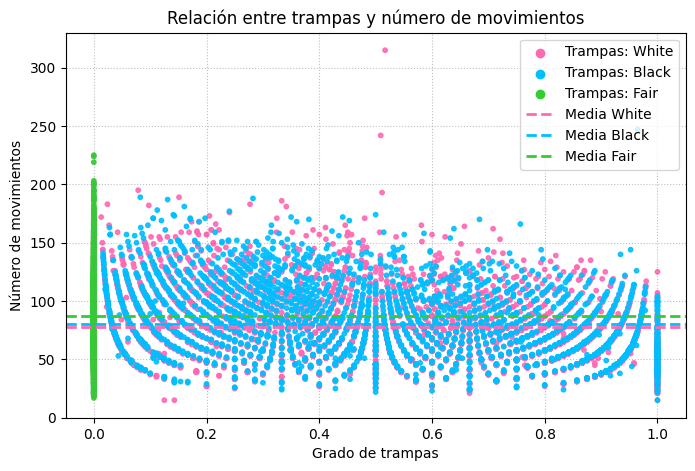

In [198]:
import numpy as np
import matplotlib.pyplot as plt

# Extraño patrón
abs_cheating_magnitude = np.abs(cheating_magnitude_np)

# Paleta de colores, por si hiciésemos más gráficos dividiendo por tipo de partida
color_map = {
    'White': '#FF69B4',  # Rosa
    'Black': '#00BFFF',  # Azul chulo
    'Fair': '#32CD32'    # Lima
}

colors = [color_map[cheating_side[i]] for i in range(len(cheating_side))]
length = [len(evals[i]) for i in range(len(evals))]

plt.figure(figsize=(8, 5))
plt.scatter(abs_cheating_magnitude, length, alpha=0.9, s=10, c=colors)

# Leyenda con colores suaves
plt.scatter([], [], color=color_map['White'], label='Trampas: White')
plt.scatter([], [], color=color_map['Black'], label='Trampas: Black')
plt.scatter([], [], color=color_map['Fair'], label='Trampas: Fair')

# Líneas de promedio para cada color
for label in ['White', 'Black', 'Fair']:
    avg_length = np.mean([length[i] for i in range(len(length)) if colors[i] == color_map[label]])
    plt.axhline(y=avg_length, color=color_map[label], linestyle='--', label=f'Media {label}', linewidth=2)

plt.legend()
plt.grid(True, linestyle=':', color='gray', alpha=0.5)
plt.xlabel('Grado de trampas')
plt.ylabel('Número de movimientos')
plt.title('Relación entre trampas y número de movimientos')
plt.show()


## Una cantidad fundamental es la precisión de los movimientos:
Para ello, calculamos la diferencia entre evaluaciones sucesivas. La evaluación asume el mejor movimiento, de manera que la diferencia será la pérdida respecto al mejor movimiento.

In [199]:

eval_diffs_fair = []
eval_diffs_cheating = []
abs_cheating_magnitude = []
for i in range(len(evals)):
    evals_i = [0.52] + evals[i] # Para blancas, el primer movimiento se mide respecto a la evaluación de la posición inicial
    eval_diffs = [abs(evals_i[j] - evals_i[j + 1]) for j in range(len(evals_i) - 1)]
    if cheating_side[i] == "White":
        eval_diffs_cheating.append(eval_diffs[::2]) # Blancas corresponden a los movimientos 0, 2, 4, ... (pares)
        abs_cheating_magnitude.append(abs(cheating_magnitude[i]))
    elif cheating_side[i] == "Black":
        eval_diffs_cheating.append(eval_diffs[1::2]) # Negras corresponden a los movimientos 1, 3, 5, ... (impares)
        abs_cheating_magnitude.append(abs(cheating_magnitude[i]))
    else:
        eval_diffs_fair.append(eval_diffs[::2])
        eval_diffs_fair.append(eval_diffs[1::2])

Peones medios perdidos por jugadores justos: 0.735176434779025
Peones medios perdidos por jugadores tramposos: 0.5879133442975158


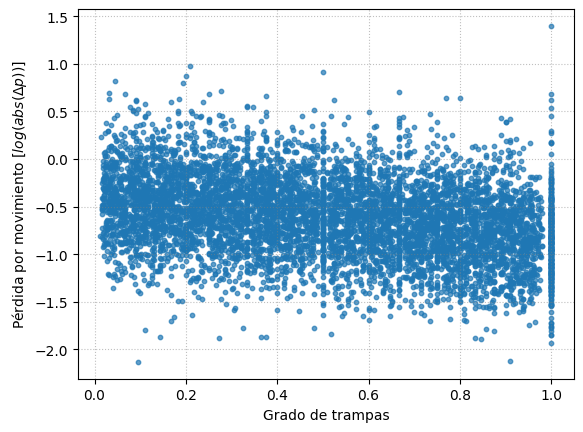

In [202]:
avg_eval_fair = np.asarray([np.sum(eval_diffs_fair[i]) / len(eval_diffs_fair[i]) for i in range(len(eval_diffs_fair))])
avg_eval_cheating = np.asarray([np.sum(eval_diffs_cheating[i]) / len(eval_diffs_cheating[i]) for i in range(len(eval_diffs_cheating))])


print(f"Peones medios perdidos por jugadores justos: {avg_eval_fair.mean()}")
print(f"Peones medios perdidos por jugadores tramposos: {avg_eval_cheating.mean()}")

plt.scatter(abs_cheating_magnitude, np.log(avg_eval_cheating), alpha=0.7, s=10, label="Mejora con trampas")
plt.xlabel("Grado de trampas")
plt.ylabel(r'Pérdida por movimiento [$log(abs(\Delta p))$]')
plt.grid(True, linestyle=':', color='gray', alpha=0.5)
plt.show()

## Análisis descriptivo desde un punto de vista funcional

En esta sección, empleamos técnicas de FDA para estudiar los datos como funciones.

- **¿Qué formas tienen de media las curvas de evaluación, dependiendo de su tipo?**
- **¿Como se relacionan las componenetes principales con el tipo de partida?**



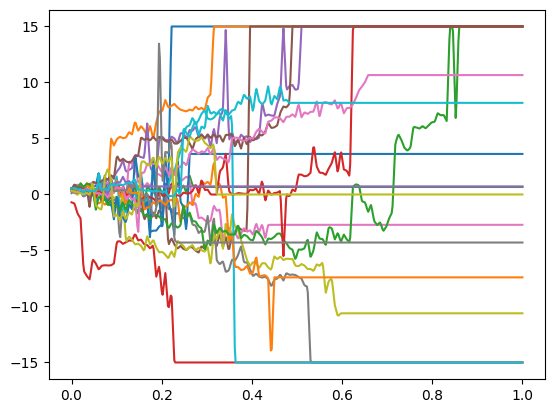

In [204]:
import skfda 

# Cargamos los datos
X = np.load('X.npy')
y = np.load('y.npy')

X_func = skfda.FDataGrid(X, grid_points=np.linspace(0, 1, 150))
X_func[:20].plot()
plt.show()

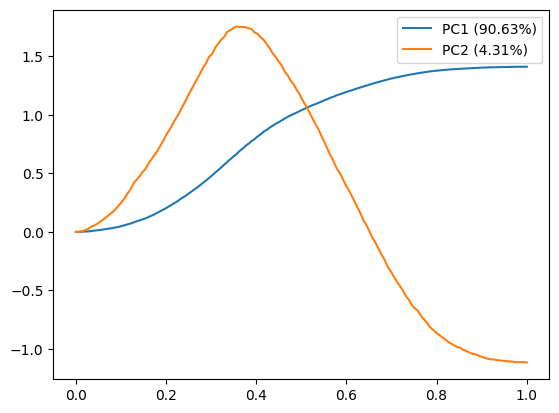

In [205]:
from skfda.preprocessing.dim_reduction import FPCA
# Realizamos una PCA para explicar al menos el 95% de la varianza

fpca = FPCA(n_components=2)   
fpca.fit(X_func)             
fpca.components_.plot()

# Adding explained variance to the legend
explained_variance = fpca.explained_variance_ratio_ * 100
plt.legend([f'PC1 ({explained_variance[0]:.2f}%)', f'PC2 ({explained_variance[1]:.2f}%)'])
plt.show()

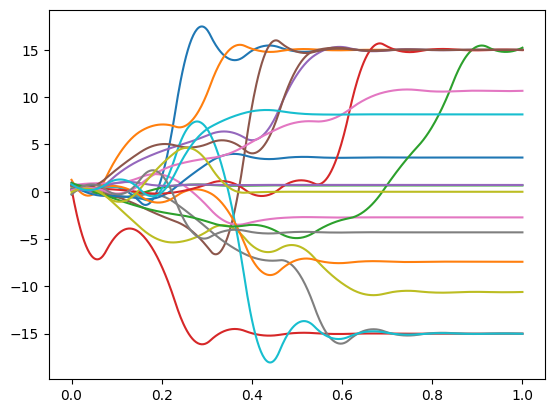

In [206]:
# Vamos a suavizar un poco los datos para ver las diferencias entre tipos de partida
from skfda.representation.basis import BSplineBasis

X_basis = X_func.to_basis(BSplineBasis(n_basis=15, order=3))
X_basis[:20].plot()
plt.show()

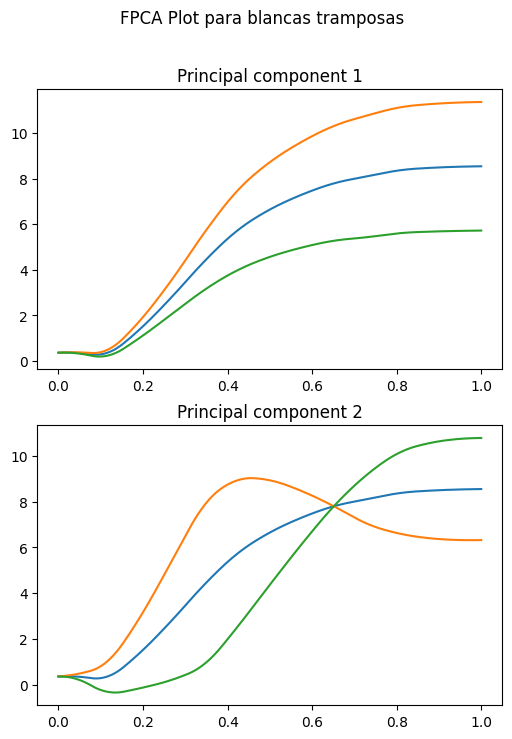

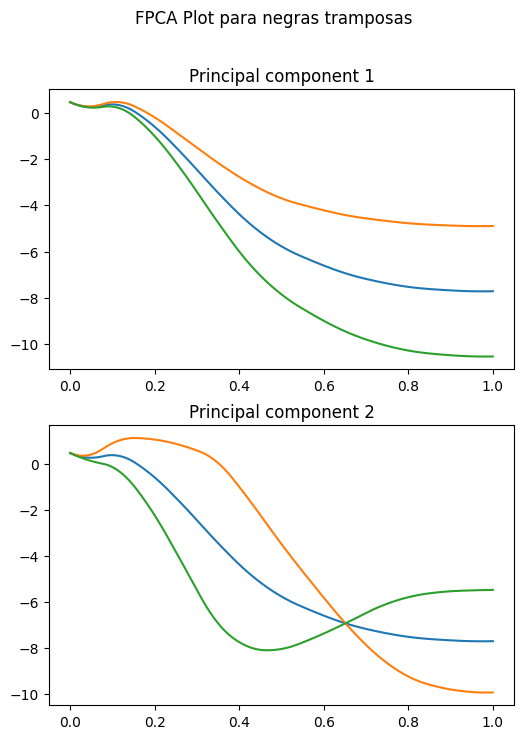

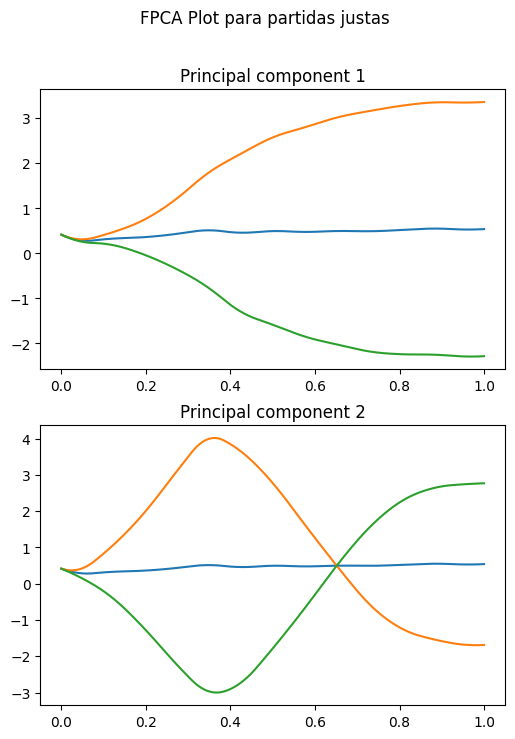

In [ ]:
from skfda.exploratory.visualization import FPCAPlot

fpca = FPCA(n_components=2)
fpca.fit(X_basis)

X_red = fpca.transform(X_basis)

# Dividimos por tipo de partida
X_func_white_cheating_red = X_red[(y == 1) & (np.asarray(cheating_side) == "White")]
X_func_white_cheating = X_basis[(y == 1) & (np.asarray(cheating_side) == "White")]

X_func_black_cheating_red = X_red[(y == 1) & (np.asarray(cheating_side) == "Black")]
X_func_black_cheating = X_basis[(y == 1) & (np.asarray(cheating_side) == "Black")]

X_func_fair_red = X_red[y == 0]
X_func_fair = X_basis[y == 0]



fig = plt.figure(figsize=(6, 2 * 4))
plt.suptitle("FPCA Plot para blancas tramposas")
fig_true = FPCAPlot(
    X_func_white_cheating.mean(),          
    fpca.components_,    
    factor=2,              
    fig=fig,
    n_rows=2,
).plot()

# FPCA plot for y=False
fig = plt.figure(figsize=(6, 2 * 4))
plt.suptitle("FPCA Plot para negras tramposas")
fig_false = FPCAPlot(
    X_func_black_cheating.mean(),        
    fpca.components_,   
    factor=2,               
    fig=fig,
    n_rows=2,
).plot()

# FPCA plot for y=False
fig = plt.figure(figsize=(6, 2 * 4))
plt.suptitle("FPCA Plot para partidas justas")
fig_false = FPCAPlot(
    X_func_fair.mean(),         
    fpca.components_,   
    factor=2,              
    fig=fig,
    n_rows=2,
).plot()


plt.show()

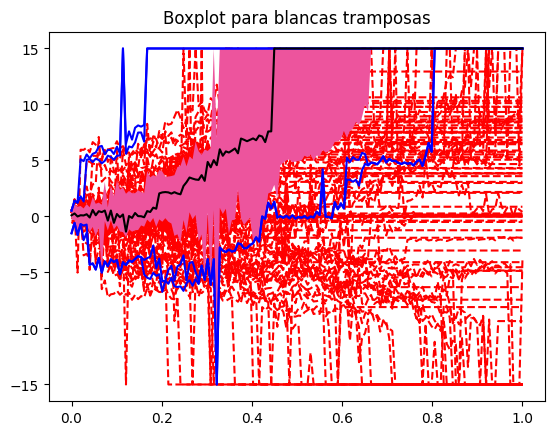

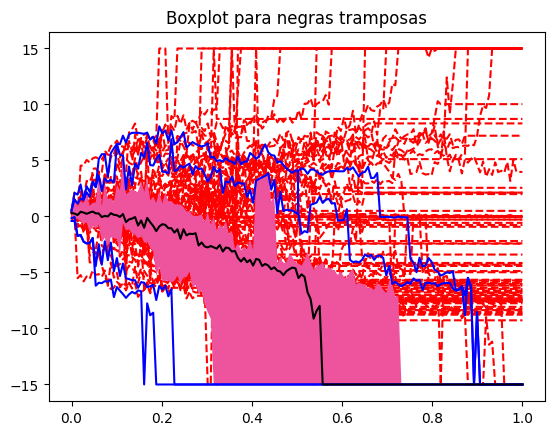

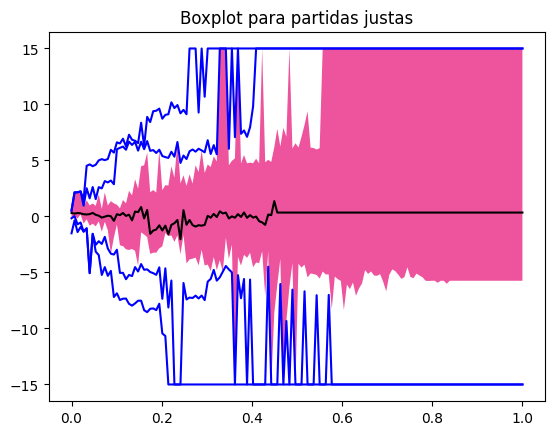

In [ ]:
from skfda.exploratory.visualization import Boxplot

# Vamos a hacer un Boxplot para hacernos una idea de la variabilidad de los datos y los outliers


X_func_white_cheating = X_func[(y == 1) & (np.asarray(cheating_side) == "White")]
X_func_black_cheating = X_func[(y == 1) & (np.asarray(cheating_side) == "Black")]
X_func_fair = X_func[y == 0]

# Nos quedamos con 200 muestras aleatorias simplemente por no saturar el gráfico
np.random.seed(0)  
X_func_white_cheating = X_func_white_cheating[np.random.choice(X_func_white_cheating.shape[0], 200, replace=False)]
X_func_black_cheating = X_func_black_cheating[np.random.choice(X_func_black_cheating.shape[0], 200, replace=False)]
X_func_fair = X_func_fair[np.random.choice(X_func_fair.shape[0], 200, replace=False)]


boxplot_white = Boxplot(X_func_white_cheating, factor=2, prob=(0.2,))
boxplot_black = Boxplot(X_func_black_cheating, factor=2, prob=(0.2,))
boxplot_fair = Boxplot(X_func_fair, factor=2, prob=(0.2,))


boxplot_white.plot()
plt.title("Boxplot para blancas tramposas")
boxplot_black.plot()
plt.title("Boxplot para negras tramposas")
boxplot_fair.plot()
plt.title("Boxplot para partidas justas")
plt.show()

# Vemos que existe mucha variabilidad y outliers: incluso en partidas tramposas ganan los jugadores honestos :)
